In [30]:
# Loading .zip folder
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [31]:
# Importing libraries for Keras part
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Dropout, Activation, Conv2D, MaxPooling2D, BatchNormalization, Flatten
from keras.models import Sequential
from keras.optimizers import rmsprop_v2
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.models import load_model
import numpy as np
import pandas as pd
import os
from keras.utils.np_utils import to_categorical
import seaborn as sns
import matplotlib.pyplot as plt
import shutil
import os
import zipfile
import cv2

In [32]:
# Creates directory, unzips folder and removes 2 unneded folders
#shutil.rmtree('./dataset')
os.mkdir("dataset")

with zipfile.ZipFile('/content/drive/Shareddrives/Visión Robótica/dataset_2.zip', 'r') as zip_ref:
    zip_ref.extractall('./dataset')

In [33]:
# Reading images and storing them in dataframe
int2emotions = {0:'angry',1:'happy',2:'neutral',3:'sad'}
emotions2int = {'angry':0,'happy':1,'neutral':2,'sad':3}

dic = {'images':[], 'labels':[], 'purpose':[]}
    
for d in os.listdir('dataset/'):
    print(d)
    for emotion in os.listdir(f'dataset/{d}'):
        print("\t",emotion)
        for i in os.listdir(f'dataset/{d}/{emotion}'):
            img = cv2.imread(f'dataset/{d}/{emotion}/{i}',0)
            img = img.reshape(48,48,1)
            
            dic['images'].append(img)
            dic['labels'].append(emotion)
            
            if d=='train':
                dic['purpose'].append('T')
            else:
                dic['purpose'].append('V')

df = pd.DataFrame(dic)
df.head()

validation
	 neutral
	 sad
	 angry
	 happy
train
	 neutral
	 sad
	 angry
	 happy


,images,labels,purpose
0,"[[[19], [15], [8], [11], [22], [22], [27], [24...",neutral,V
1,"[[[208], [212], [218], [220], [218], [213], [1...",neutral,V
2,"[[[152], [141], [122], [46], [23], [31], [57],...",neutral,V
3,"[[[20], [17], [19], [21], [17], [15], [18], [1...",neutral,V
4,"[[[68], [71], [73], [75], [75], [75], [79], [7...",neutral,V


In [34]:
# Extracting training and validation data
train_data = df[df['purpose']=='T']
val_data = df[df['purpose']=='V']

In [35]:
# Counting training instances
train_data['labels'].value_counts()

happy      7164
neutral    4982
sad        4938
angry      3993
Name: labels, dtype: int64

In [36]:
# Taking equal instances of all classes
happy_df = train_data[train_data['labels']=='happy'].sample(n=7164)
neutral_df = train_data[train_data['labels']=='neutral'].sample(n=4982)
sad_df = train_data[train_data['labels']=='sad'].sample(n=4938)
angry_df = train_data[train_data['labels']=='angry'].sample(n=3993)

train_data = pd.concat([happy_df, neutral_df, sad_df, angry_df])

train_data = train_data.sample(frac=1)
train_data.reset_index(inplace=True)
train_data.drop('index',inplace=True,axis=1)

train_data.head()

,images,labels,purpose
0,"[[[41], [32], [27], [21], [19], [31], [33], [3...",happy,T
1,"[[[208], [191], [214], [225], [225], [223], [1...",sad,T
2,"[[[132], [132], [132], [131], [132], [133], [1...",neutral,T
3,"[[[253], [255], [253], [255], [249], [249], [1...",angry,T
4,"[[[75], [83], [86], [46], [54], [48], [52], [5...",neutral,T


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


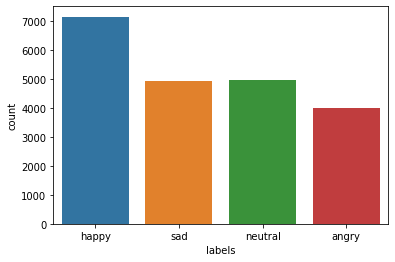

In [37]:
# Checking values again
train_data['labels'].value_counts()
sns.countplot(train_data['labels'])

In [38]:
# Declaring constants
batch_size= 32
classes = 4
rows,columns=48,48

In [39]:
# Parse emotions to integers
train_labels = list(train_data['labels'].replace(emotions2int))
train_labels = to_categorical(train_labels)
val_labels = list(val_data['labels'].replace(emotions2int))
val_labels = to_categorical(val_labels)
train_data = list(train_data['images'])
train_data = np.array(train_data)
val_data = list(val_data['images'])
val_data = np.array(val_data)

In [40]:
# Checking data shape
print(train_data.shape)
print(val_data.shape)

(21077, 48, 48, 1)
(5140, 48, 48, 1)


In [41]:
# Creating emotion detector model
model = Sequential()
# First Block
model.add(Conv2D(64,(3,3),activation='relu',input_shape=(rows,columns,1),kernel_initializer='he_normal',padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(64,(3,3),activation='relu',input_shape=(rows,columns,1),kernel_initializer='he_normal',padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))
# Second Block
model.add(Conv2D(128,(3,3),activation='relu',kernel_initializer='he_normal',padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(128,(3,3),activation='relu',kernel_initializer='he_normal',padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))
# Third Block
model.add(Conv2D(256,(3,3),activation='relu',kernel_initializer='he_normal',padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(256,(3,3),activation='relu',kernel_initializer='he_normal',padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))
# Fourth Block
model.add(Conv2D(512,(3,3),activation='relu',kernel_initializer='he_normal',padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(512,(3,3),activation='relu',kernel_initializer='he_normal',padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))
# Fifth Block
model.add(Flatten())
model.add(Dense(256,activation='relu',kernel_initializer='he_normal'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
# Sixth Block
model.add(Dense(128,activation='relu',kernel_initializer='he_normal'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
# Seventh Block
model.add(Dense(64,activation='relu',kernel_initializer='he_normal'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
# Eighth Block
model.add(Dense(classes,activation='softmax',kernel_initializer='he_normal'))
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 48, 48, 64)        640       
                                                                 
 batch_normalization_11 (Bat  (None, 48, 48, 64)       256       
 chNormalization)                                                
                                                                 
 conv2d_9 (Conv2D)           (None, 48, 48, 64)        36928     
                                                                 
 batch_normalization_12 (Bat  (None, 48, 48, 64)       256       
 chNormalization)                                                
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 24, 24, 64)       0         
 2D)                                                             
                                                      

In [42]:
# Declaring callbacks
checkpoint = ModelCheckpoint('model\\6_class_emotion_detector_V2.h5',
                             save_best_only=True,
                             mode='min',
                             monitor='val_loss',
                             verbose=1)
earlystopping = EarlyStopping(patience=10,
                             verbose=1,
                             min_delta=0,
                             monitor='val_loss',
                             restore_best_weights=True)
callbacks = [checkpoint, earlystopping]
model.compile(metrics=['accuracy'],
             optimizer='rmsprop',
             loss='categorical_crossentropy')

In [43]:
# Training the model
train_samples = 28273
validation_samples = 3534
batch_size = 64
epochs=30
history = model.fit(train_data,
                    train_labels,
                    epochs=epochs,
                    steps_per_epoch=train_samples//batch_size,
                    validation_data=(val_data,val_labels),
                    validation_steps=validation_samples//batch_size,
                    callbacks=callbacks)

Epoch 1/30
440/441 [============================>.] - ETA: 0s - loss: 1.7016 - accuracy: 0.2735
Epoch 1: val_loss improved from inf to 1.40586, saving model to model\6_class_emotion_detector_V2.h5
441/441 [==============================] - 22s 44ms/step - loss: 1.7010 - accuracy: 0.2734 - val_loss: 1.4059 - val_accuracy: 0.3344
Epoch 2/30
441/441 [==============================] - ETA: 0s - loss: 1.3974 - accuracy: 0.3110
Epoch 2: val_loss improved from 1.40586 to 1.39707, saving model to model\6_class_emotion_detector_V2.h5
441/441 [==============================] - 19s 43ms/step - loss: 1.3974 - accuracy: 0.3110 - val_loss: 1.3971 - val_accuracy: 0.3350
Epoch 3/30
441/441 [==============================] - ETA: 0s - loss: 1.3313 - accuracy: 0.3653
Epoch 3: val_loss improved from 1.39707 to 1.23896, saving model to model\6_class_emotion_detector_V2.h5
441/441 [==============================] - 19s 42ms/step - loss: 1.3313 - accuracy: 0.3653 - val_loss: 1.2390 - val_accuracy: 0.4253
Ep

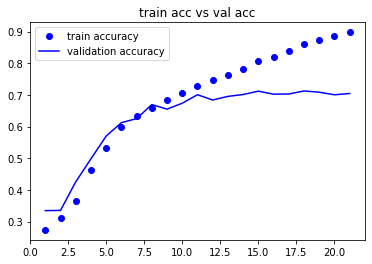

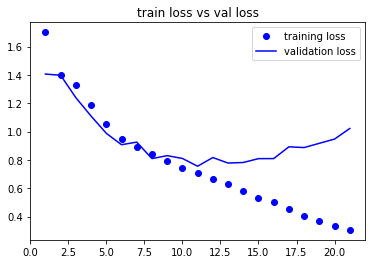

In [44]:
# Showing epochs graph
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc)+1)

plt.plot(epochs,acc,'bo',label='train accuracy')
plt.plot(epochs,val_acc, 'b', label='validation accuracy')
plt.title('train acc vs val acc')
plt.legend()

plt.figure()

plt.plot(epochs,loss, 'bo', label ='training loss')
plt.plot(epochs,val_loss, 'b', label = 'validation loss')
plt.title('train loss vs val loss')
plt.legend()

plt.show()

In [46]:
# import dependencies
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from base64 import b64decode, b64encode
import numpy as np
import PIL
import io
import html
import time
from keras.models import load_model

In [47]:
# function to convert the JavaScript object into an OpenCV image
def js_to_image(js_reply):
  """
  Params:
          js_reply: JavaScript object containing image from webcam
  Returns:
          img: OpenCV BGR image
  """
  # decode base64 image
  image_bytes = b64decode(js_reply.split(',')[1])
  # convert bytes to numpy array
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  # decode numpy array into OpenCV BGR image
  img = cv2.imdecode(jpg_as_np, flags=1)

  return img

# function to convert OpenCV Rectangle bounding box image into base64 byte string to be overlayed on video stream
def bbox_to_bytes(bbox_array):
  """
  Params:
          bbox_array: Numpy array (pixels) containing rectangle to overlay on video stream.
  Returns:
        bytes: Base64 image byte string
  """
  # convert array into PIL image
  bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')
  iobuf = io.BytesIO()
  # format bbox into png for return
  bbox_PIL.save(iobuf, format='png')
  # format return string
  bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))

  return bbox_bytes

In [48]:
# maps emotions, loads trained model and initializes the Haar Cascade face detection model
int2emotions = {0:'angry',1:'happy',2:'neutral',3:'sad'}
model = load_model('model\\6_class_emotion_detector_V2.h5')
face_cascade = cv2.CascadeClassifier(cv2.samples.findFile(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml'))

In [49]:
# JavaScript to properly create our live video stream using our webcam as input
def video_stream():
  js = Javascript('''
    var video;
    var div = null;
    var stream;
    var captureCanvas;
    var imgElement;
    var labelElement;
    
    var pendingResolve = null;
    var shutdown = false;
    
    function removeDom() {
       stream.getVideoTracks()[0].stop();
       video.remove();
       div.remove();
       video = null;
       div = null;
       stream = null;
       imgElement = null;
       captureCanvas = null;
       labelElement = null;
    }
    
    function onAnimationFrame() {
      if (!shutdown) {
        window.requestAnimationFrame(onAnimationFrame);
      }
      if (pendingResolve) {
        var result = "";
        if (!shutdown) {
          captureCanvas.getContext('2d').drawImage(video, 0, 0, 640, 480);
          result = captureCanvas.toDataURL('image/jpeg', 0.8)
        }
        var lp = pendingResolve;
        pendingResolve = null;
        lp(result);
      }
    }
    
    async function createDom() {
      if (div !== null) {
        return stream;
      }

      div = document.createElement('div');
      div.style.border = '2px solid black';
      div.style.padding = '3px';
      div.style.width = '100%';
      div.style.maxWidth = '600px';
      document.body.appendChild(div);
      
      const modelOut = document.createElement('div');
      modelOut.innerHTML = "<span>Status:</span>";
      labelElement = document.createElement('span');
      labelElement.innerText = 'No data';
      labelElement.style.fontWeight = 'bold';
      modelOut.appendChild(labelElement);
      div.appendChild(modelOut);
           
      video = document.createElement('video');
      video.style.display = 'block';
      video.width = div.clientWidth - 6;
      video.setAttribute('playsinline', '');
      video.onclick = () => { shutdown = true; };
      stream = await navigator.mediaDevices.getUserMedia(
          {video: { facingMode: "environment"}});
      div.appendChild(video);

      imgElement = document.createElement('img');
      imgElement.style.position = 'absolute';
      imgElement.style.zIndex = 1;
      imgElement.onclick = () => { shutdown = true; };
      div.appendChild(imgElement);
      
      const instruction = document.createElement('div');
      instruction.innerHTML = 
          '<span style="color: red; font-weight: bold;">' +
          'When finished, click here or on the video to stop this demo</span>';
      div.appendChild(instruction);
      instruction.onclick = () => { shutdown = true; };
      
      video.srcObject = stream;
      await video.play();

      captureCanvas = document.createElement('canvas');
      captureCanvas.width = 640; //video.videoWidth;
      captureCanvas.height = 480; //video.videoHeight;
      window.requestAnimationFrame(onAnimationFrame);
      
      return stream;
    }
    async function stream_frame(label, imgData) {
      if (shutdown) {
        removeDom();
        shutdown = false;
        return '';
      }

      var preCreate = Date.now();
      stream = await createDom();
      
      var preShow = Date.now();
      if (label != "") {
        labelElement.innerHTML = label;
      }
            
      if (imgData != "") {
        var videoRect = video.getClientRects()[0];
        imgElement.style.top = videoRect.top + "px";
        imgElement.style.left = videoRect.left + "px";
        imgElement.style.width = videoRect.width + "px";
        imgElement.style.height = videoRect.height + "px";
        imgElement.src = imgData;
      }
      
      var preCapture = Date.now();
      var result = await new Promise(function(resolve, reject) {
        pendingResolve = resolve;
      });
      shutdown = false;
      
      return {'create': preShow - preCreate, 
              'show': preCapture - preShow, 
              'capture': Date.now() - preCapture,
              'img': result};
    }
    ''')

  display(js)
  
def video_frame(label, bbox):
  data = eval_js('stream_frame("{}", "{}")'.format(label, bbox))
  return data

In [50]:
# start streaming video from webcam
video_stream()
# label for video
label_html = 'Capturing...'
# initialze bounding box to empty
bbox = ''
count = 0 
while True:
    js_reply = video_frame(label_html, bbox)
    if not js_reply:
        break

    # convert JS response to OpenCV Image
    img = js_to_image(js_reply["img"])

    # create transparent overlay for bounding box
    bbox_array = np.zeros([480,640,4], dtype=np.uint8)

    # grayscale image for face detection
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # get face region coordinates
    faces = face_cascade.detectMultiScale(gray)

    # get face bounding box for overlay
    for (x,y,w,h) in faces:
      bbox_array = cv2.rectangle(bbox_array,(x,y),(x+w,y+h),(255,0,0),2)

      face = gray[y:y+h,x:x+w]
      face = cv2.resize(face,(48,48))
      face = face.reshape(1,48,48,1)

      predictionPercentages = model.predict(face)
      predictedEmotionName = int2emotions[np.argmax(predictionPercentages)]
      emotionPercentage = round(np.max(predictionPercentages)*100, 2)

      cv2.putText(bbox_array,text=predictedEmotionName + "=" + str(emotionPercentage) + "%",
                    org=(x,y-15),fontFace=cv2.FONT_HERSHEY_SIMPLEX,fontScale=1,color=(0, 233, 0),thickness=2)

    bbox_array[:,:,3] = (bbox_array.max(axis = 2) > 0 ).astype(int) * 255
    # convert overlay of bbox into bytes
    bbox_bytes = bbox_to_bytes(bbox_array)
    # update bbox so next frame gets new overlay
    bbox = bbox_bytes

<IPython.core.display.Javascript object>